In this PySpark notebook, we'll explore flights data for January 2016 from the U.S. Bureau of Transportation Statistics. 

After loading data in the Flights RDD, we'll do the following operations:

1. Calculate the average distance travelled by a flight using **Reduce** method
2. Caluclate the percentage of flights with delays
3. Calculate the average delay per flight using **Aggregate** method
4. Build a histogram using **CountByValue** method

Then, we'll load airports data in a pair RDD and do the following:

1. Calculate total delay per airport using **reduceByKey**

2. Count number of flights per airport using **mapValues and reduceByKey**: map each value to 1 then sum up the ones.

3. Calculate average delay per airport using the previous results, and show the 10 airports with largest delays


In [1]:
sc

In [2]:
# Set up file paths. 
# I'm using a Google Dataproc cluster and the files are stored in a Google storage bucket
airportsPath="gs://bs_spark_bucket/Airlines_data/airports.csv"
flightsPath="gs://bs_spark_bucket/Airlines_data/flights.csv"

### Create the Flights RDD that contains data for 445 827 flights

Each row in the flights RDD is **a string** that contains information about a specific flight (Flight date, Airline ID, Flight number, Origin, Destination, Departure time, Departure delay, Arrival Time, Arrival delay, Air time 
and Distance traveled).

We want to create an RDD of **flight objects** and for that we'll:

1- Remove the header and split each row into a list

2- Build a class and a function to create a flight object from each row 

In [6]:
# Get data from the csv file 
flights = sc.textFile(flightsPath)

In [45]:
# Let's see how many flights we have
flights.count()

445828

In [46]:
flights.take(10)

[u'"FL_DATE","AIRLINE_ID","FL_NUM","ORIGIN","DEST","DEP_TIME","DEP_DELAY","ARR_TIME","ARR_DELAY","AIR_TIME","DISTANCE",',
 u'2016-01-01,19805,"43","DTW","DFW","1539",26.00,"1756",32.00,149.00,986.00,',
 u'2016-01-01,19805,"44","SEA","JFK","0741",-4.00,"1610",8.00,294.00,2422.00,',
 u'2016-01-01,19805,"45","JFK","SEA","1819",-6.00,"2125",-25.00,324.00,2422.00,',
 u'2016-01-01,19805,"46","SJC","ORD","1423",-2.00,"2029",-14.00,220.00,1829.00,',
 u'2016-01-01,19805,"47","ORD","SJC","1746",-4.00,"2007",-27.00,245.00,1829.00,',
 u'2016-01-01,19805,"48","PHX","DFW","1115",0.00,"1431",-12.00,109.00,868.00,',
 u'2016-01-01,19805,"52","LAX","DCA","1443",83.00,"2217",62.00,253.00,2311.00,',
 u'2016-01-01,19805,"53","ORD","TPA","1510",10.00,"1848",9.00,132.00,1012.00,',
 u'2016-01-01,19805,"54","MCO","ORD","1406",15.00,"1554",0.00,152.00,1005.00,']

In [7]:
# Remove header and split each row into a list
flightsWoHeader = flights.filter(lambda x: "FL_DATE" not in x).map(lambda x:x.split(','))

In [8]:
# Remove blank records
flightsWoHeader = flightsWoHeader.filter(lambda x:x[6] != "")

In [10]:
flightsWoHeader.count()

434354

In [11]:
# Let's build a class and a function to transform each row into a flight object
from datetime import datetime
from collections import namedtuple


# Use namedtuple to create a Flight class
fields   = ('date', 'airline', 'flightnum', 'origin', 'dest', 'dep',
            'dep_delay', 'arv', 'arv_delay', 'airtime', 'distance')
Flight   = namedtuple('Flight', fields, verbose=False)


# Create a function to build a flight object from each row. The function also converts
# dep_delay and distance to floats.
def parse(row):
    row[6]  = float(row[6])
    row[10] = float(row[10])
    return Flight(*row[:11])

Now let's use our new function to create an **RDD of flight objects**

In [12]:
flightsParsed = flightsWoHeader.map(parse)

### FLIGHTS data analysis - Average Distance travelled and Average Delays

We want to:
1. Calculate the average distance travelled by a flight using **Reduce** method

2. Caluclate the percentage of flights with delays

3. Calculate the average delay per flight using **Aggregate** method

4. Build a histogram using **CountByValue** method

Average distance travelled by a flight using **Reduce**

In [59]:
# Let's find the average distance travelled by a flight
totalDistance=flightsParsed.map(lambda x:x.distance).reduce(lambda x,y:x+y)

In [14]:
avgDistance = totalDistance / flightsParsed.count()

In [15]:
avgDistance

843.8915492892894

In [16]:
# Find the percentage of flights with delays 
flightsParsed.filter(lambda x:x.dep_delay>0).count()/float(flightsParsed.count())

0.3433627870354596

Average delay per flight using **Aggregate**

The Aggregate method allows us to define:
- a function to combine results on individual nodes
- and another function to combine results for all nodes 

In [56]:
# We get a tuple where the first value is the total delay and the second value is the number of flights

sumCount=flightsParsed.map(lambda x:x.dep_delay).aggregate(# Zero value
                                                           (0,0), 
                                                           # Function to combine results on individual nodes
                                                          (lambda acc,value: (acc[0]+value, acc[1]+1)),
                                                           # Function to combine results from all nodes 
                                                          (lambda acc1,acc2:(acc1[0]+acc2[0],acc1[1]+acc2[1])))

In [93]:
sumCount

(3385154.0, 434354)

In [101]:
print "The average delay per flight is "+str(round(sumCount[0]/float(sumCount[1]),2)) + " hours."

The average delay per flight is 7.79 hours.


Histogram of delays using **CountByValue**

In [112]:
histData = flightsParsed.map(lambda x:int(x.dep_delay/60)).countByValue()

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

In [124]:
df_pd = pd.DataFrame(histData.items(), columns=['Delay_hrs', 'Frequency'])

In [130]:
df_pd[df_pd['Delay_hrs']>0].plot(kind='bar')

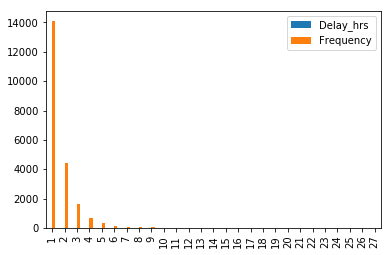

In [131]:
plt.show()

### AIRPORTS - data analysis

1. Create a pair RDD airportDelays

2. Calculate total delay per airport using **reduceByKey**

3. Count number of flights per airport using **mapValues and reduceByKey**: map each value to 1 then sum up the ones.

4. Calculate average delay per airport using the previous results, and show the 10 airports with greatest delays

In [17]:
# Create a pair RDD where the keys are airports symbols and values are departure delays
airportDelays = flightsParsed.map(lambda x: (x.origin,x.dep_delay))

In [18]:
airportDelays.keys().take(10)

[u'"DTW"',
 u'"SEA"',
 u'"JFK"',
 u'"SJC"',
 u'"ORD"',
 u'"PHX"',
 u'"LAX"',
 u'"ORD"',
 u'"MCO"',
 u'"DEN"']

In [19]:
airportDelays.values().take(10)

[26.0, -4.0, -6.0, -2.0, -4.0, 0.0, 83.0, 10.0, 15.0, -5.0]

Calculate total delay per airport using **reduceByKey**

In [20]:
# First find the total delay per airport
airportTotalDelay=airportDelays.reduceByKey(lambda x,y:x+y)

In [58]:
airportTotalDelay.take(10)

[(u'"DAB"', 1885.0),
 (u'"TXK"', 84.0),
 (u'"ACY"', 2808.0),
 (u'"ONT"', 14015.0),
 (u'"MLB"', 115.0),
 (u'"ASE"', 6425.0),
 (u'"FLG"', 216.0),
 (u'"GUC"', -4.0),
 (u'"TYR"', -653.0),
 (u'"BLI"', -397.0)]

Count number of flights per airport using **mapValues and reduceByKey**: map each value to 1 then sum up the ones.

In [21]:
# Find the flights count per airport
airportCount=airportDelays.mapValues(lambda x:1).reduceByKey(lambda x,y:x+y)

In [22]:
airportCount.take(10)

[(u'"DAB"', 145),
 (u'"TXK"', 82),
 (u'"ACY"', 294),
 (u'"ONT"', 1574),
 (u'"MLB"', 117),
 (u'"ASE"', 580),
 (u'"FLG"', 146),
 (u'"GUC"', 48),
 (u'"TYR"', 170),
 (u'"BLI"', 94)]

In [51]:
# Join the two RDDs to have delays and flight count in 1 RDD 
airportSumCount=airportTotalDelay.join(airportCount)

In [52]:
airportSumCount.take(10)

[(u'"DAB"', (1885.0, 145)),
 (u'"TXK"', (84.0, 82)),
 (u'"ACY"', (2808.0, 294)),
 (u'"ONT"', (14015.0, 1574)),
 (u'"MLB"', (115.0, 117)),
 (u'"ASE"', (6425.0, 580)),
 (u'"FLG"', (216.0, 146)),
 (u'"GUC"', (-4.0, 48)),
 (u'"TYR"', (-653.0, 170)),
 (u'"BLI"', (-397.0, 94))]

In [53]:
# Compute average delay per airport 
airportAvgDelay=airportSumCount.mapValues(lambda x : round(x[0]/float(x[1]),2))

In [60]:
# Airports with largest delays
airportAvgDelay.sortBy(lambda x:-x[1]).take(10)

[(u'"COD"', 53.0),
 (u'"MQT"', 44.34),
 (u'"BRD"', 35.81),
 (u'"HIB"', 33.72),
 (u'"APN"', 33.48),
 (u'"CMX"', 31.75),
 (u'"OTH"', 21.88),
 (u'"FAR"', 20.44),
 (u'"SWF"', 20.32),
 (u'"PLN"', 19.82)]